# Идентификация видов стекла.

###  Постановка задачи.

Выборка состоит из 9 признаков - химических параметров образцов и 214 объектов. Необходимо каждому образцу сопоставить один из 6 классов (например: стекло автомобиля, осколок посуды, окно здания).

**Метрика качества** - доля правильных ответов классификатора (`accuracy`). 

**Цель**

1.$ $ Решить задачу с использованием следующих методов:

1) Алгоритм k ближайших соседей,

2) Алгоритм решающего дерева

и сравнить качество их работы. 

2.$ $ Отмасштабировать признаки и проверить, даст ли такая процедура увеличение значения `accuracy`.

3.$ $ Выбрать наиболее точный из алгоритмов и исследовать зависимость `accuracy`, достигаемое этим алгоритмом на разных количествах признаков.

In [2]:
# подключение используемых библиотек
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline

# используемые модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# вспомогательные функции
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# необходимые параметры для графиков
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [3]:
data = pd.read_csv('glass.data', header=None).sample(frac=1, random_state=77)[np.arange(1, 11)]

In [4]:
data.head()

,1,2,3,4,5,6,7,8,9,10
20,1.51750,12.82,3.55,1.49,72.75,0.54,8.52,0.0,0.19,1
178,1.51829,14.46,2.24,1.62,72.38,0.00,9.26,0.0,0.00,6
17,1.52196,14.36,3.85,0.89,71.36,0.15,9.15,0.0,0.00,1
16,1.51784,12.68,3.67,1.16,73.11,0.61,8.70,0.0,0.00,1
58,1.51754,13.48,3.74,1.17,72.99,0.59,8.03,0.0,0.00,1


In [5]:
X = data[np.arange(1, 10)]
y = data[10]

# разделим исходные данные на train и на test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42
)

X_train.head()

,1,2,3,4,5,6,7,8,9
190,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00
158,1.51776,13.53,3.41,1.52,72.04,0.58,8.79,0.00,0.00
89,1.51640,12.55,3.48,1.87,73.23,0.63,8.08,0.00,0.09
192,1.51623,14.20,0.00,2.79,73.46,0.04,9.04,0.40,0.09
177,1.51937,13.79,2.41,1.19,72.76,0.00,9.77,0.00,0.00


**Классификация с использованием метода k ближайших соседей.**

In [6]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)
predictions_knn = knn_classifier.predict(X_test)
print(accuracy_score(predictions_knn, y_test))

0.6461538461538462


**Классификация с использованием решающего дерева.**

In [7]:
rf_classifier = DecisionTreeClassifier(random_state=42, max_depth=10)
rf_classifier.fit(X_train, y_train)
predictions_rf = rf_classifier.predict(X_test)
print(accuracy_score(predictions_rf, y_test))

0.6615384615384615


### Масштабирование признаков.

In [8]:
X_scaled_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_scaled_test = (X_test - np.mean(X_train)) / np.std(X_train)

In [9]:
knn_classifier.fit(X_scaled_train, y_train)
predictions = knn_classifier.predict(X_scaled_test)
print(accuracy_score(predictions, y_test))

0.676923076923077


In [10]:
rf_classifier.fit(X_scaled_train, y_train)
predictions_rf = rf_classifier.predict(X_scaled_test)
print(accuracy_score(predictions_rf, y_test))

0.6615384615384615


**Вывод.**

После масштабирования признаков точность метода k ближайших соседей повысилась, а метода решающих деревьев - осталась такой же, как и до масштабирования.

Поскольку точность метода k ближайших соседей оказалась выше, будем в дальнейших экспериментах использовать именно его.

### Отбор признаков.

Отбор признаков будем производить жадным образом. А именно, будем на каждом шаге из недобавленных признаков выбирать такой, что его добавление максимизирует метрику качества на тесте.

In [12]:
# набор признаков, используемых в модели
rows_set = []
# значения accuracy на обучении и тесте при разных количествах признаков
accuracy_train = []
accuracy_test = []
# значения дисперсий accuracy при разных количествах признаков
var_train = []
var_test = []

# подсчёт значения accuracy на произвольном dataset-е
def get_accuracy(dataset_X, dataset_y):
    knn_classifier.fit(X_scaled_train[rows_set], y_train)
    cur_predict = knn_classifier.predict(dataset_X)
    return accuracy_score(cur_predict, dataset_y)  

# подсчёт значения accuracy на обучении
def get_train_accuracy():
    return get_accuracy(X_scaled_train[rows_set], y_train)    

# подсчёт значения accuracy на тесте
def get_test_accuracy():
    return get_accuracy(X_scaled_test[rows_set], y_test)    

# подсчёт дисперсии  по методу бутстрепа
def get_variance(dataset_X, dataset_y):
    n = len(dataset_y)
    B = int(n**(12.0/10))
    sample_accuracy = []
    
    for sample_id in range(B):
        item_ids = sps.randint(low=0, high=n).rvs(n)
        sample_accuracy.append(get_accuracy(dataset_X[rows_set].values[item_ids,],
                                            dataset_y.values[item_ids,]))
    return np.var(sample_accuracy)
    
# перебираем число признаков, которые будут использованы в предсказании
for feature_cnt in range(1, 10):
    best_to_add = -1
    best_accuracy = 0.0
    # перебираем номер признака, который будет добавлен
    for feature_id in range(1, 10):
        if feature_id not in rows_set:
            rows_set.append(feature_id)
            cur_accuracy = get_test_accuracy()
            rows_set.remove(feature_id)
            if (cur_accuracy > best_accuracy) or (best_to_add == -1):
                best_to_add = feature_id
                best_accuracy = cur_accuracy
                
    rows_set.append(best_to_add)
    accuracy_test.append(best_accuracy)
    accuracy_train.append(get_train_accuracy())
    var_train.append(get_variance(X_scaled_train, y_train))
    var_test.append(get_variance(X_scaled_test, y_test))
    
    print("набор признаков: ", rows_set)
    print("test accuracy: ", best_accuracy, 
          "train accuracy: ", get_train_accuracy())

набор признаков:  [4]
test accuracy:  0.6 train accuracy:  0.6510067114093959
набор признаков:  [4, 1]
test accuracy:  0.7076923076923077 train accuracy:  0.7986577181208053
набор признаков:  [4, 1, 5]
test accuracy:  0.7076923076923077 train accuracy:  0.8120805369127517
набор признаков:  [4, 1, 5, 8]
test accuracy:  0.7384615384615385 train accuracy:  0.8523489932885906
набор признаков:  [4, 1, 5, 8, 6]
test accuracy:  0.7384615384615385 train accuracy:  0.8389261744966443
набор признаков:  [4, 1, 5, 8, 6, 7]
test accuracy:  0.7538461538461538 train accuracy:  0.8389261744966443
набор признаков:  [4, 1, 5, 8, 6, 7, 2]
test accuracy:  0.7538461538461538 train accuracy:  0.8187919463087249
набор признаков:  [4, 1, 5, 8, 6, 7, 2, 3]
test accuracy:  0.7384615384615385 train accuracy:  0.8120805369127517
набор признаков:  [4, 1, 5, 8, 6, 7, 2, 3, 9]
test accuracy:  0.676923076923077 train accuracy:  0.825503355704698


In [13]:
accuracy_test = np.array(accuracy_test)
accuracy_train = np.array(accuracy_train)
var_test = np.array(var_test)
var_train = np.array(var_train)

### Построение графиков

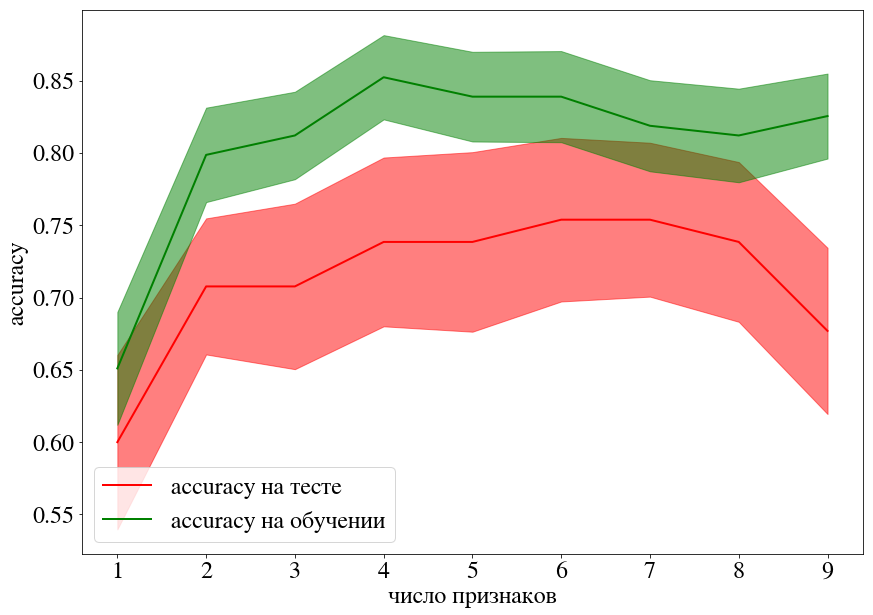

In [18]:
plt.figure(figsize=(14, 10))

plt.plot(
    np.arange(1, 10), 
    accuracy_test, 
    color="red", 
    label="accuracy на тесте"
)

plt.fill_between(
    np.arange(1, 10),      
    accuracy_test - np.sqrt(var_test), 
    accuracy_test + np.sqrt(var_test),
    alpha=0.5,
    color="red"
)

plt.plot(
    np.arange(1, 10), 
    accuracy_train, 
    color="green", 
    label="accuracy на обучении"
)

plt.fill_between(
    np.arange(1, 10),      
    accuracy_train - np.sqrt(var_train), 
    accuracy_train + np.sqrt(var_train),
    alpha=0.5,
    color="green"
)

plt.xlabel("число признаков")
plt.ylabel("accuracy")
plt.legend()
plt.show()

**Вывод.**

Как можно увидеть по построенному графику, начиная с 6 признаков, точность работы алгоритма на тестовой выборке начинает ухудшаться. Кроме того, наилучшее значение `accuracy` на обучающей выборке достигается, когда число признаков равно 4.

Это значит, что в данных есть как минимум 3 незначимых признака, от которых необходимо избавиться, чтобы избежать переобучения. 

